In [6]:
import torch.nn as nn
import sys
import os
project_root = os.path.abspath("..")  # Adjust if needed
import pytorch_lightning as pl
# Add the project root to sys.path
if project_root not in sys.path:
    sys.path.append(project_root)

from src.utils.data_utils import *
from src.dataset_classes.pointDataset import *
from proteinshake.datasets import ProteinFamilyDataset
from proteinshake.tasks import LigandAffinityTask
import random
from src.models.graphVAE import GraphVAE
from torch.utils.data import Dataset, Subset

from src.utils.data_utils import *
from torch_geometric.loader import DataLoader
from src.dataset_classes.graphDataset import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
dataset = ProteinFamilyDataset(root='../data').to_graph(eps = 8).pyg()
dataset = load_graph_data(dataset)
batch_size = 128
loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [54]:
# Load the trained model from checkpoint
checkpoint_path = "../trained_models/Pfam/optimise_graphvae/18-27-03_SWEEP_Pfam_GraphVAE_study_BS128_MS500_trials5 2/4_LD128_HD256_Beta0.05_GCH32.ckpt"
model = GraphVAE.load_from_checkpoint(checkpoint_path)

# Put model in evaluation mode
model.eval()

/opt/anaconda3/envs/ProteinManifoldLearning/lib/python3.10/site-packages/pytorch_lightning/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.5.1, which is newer than your current Lightning version: v2.5.0.post0


GraphVAE(
  (conv1): GCNConv(20, 32)
  (conv2): GCNConv(32, 64)
  (fc_mu): Linear(in_features=32000, out_features=128, bias=True)
  (fc_logvar): Linear(in_features=32000, out_features=128, bias=True)
  (fc1_dec): Linear(in_features=128, out_features=256, bias=True)
  (fc2_dec_feature): Linear(in_features=256, out_features=10000, bias=True)
  (fc_adj_dec): Linear(in_features=128, out_features=32000, bias=True)
  (tanh): Tanh()
  (sigmoid): Sigmoid()
  (soft): Softmax(dim=-1)
)

In [55]:
batch_test = next(iter(loader))
torch.sum(batch_test.x.argmax(-1) == 0)

tensor(37630)

In [56]:
labels = []
latent_coord = []
model.eval()
total_samples = []
lengths = []
i_amino_count = {i:[] for i in range(21)}
for batch_i, batch in enumerate(loader):
    for batch_sample in range(batch.batch[-1]+1):
        lengths.append(torch.sum(batch[batch_sample].x).int().item())
    # for i in range(21):
    #     i_amino_count[i].extend(torch.sum(batch.argmax(-1) == i, axis = -1))
    # labels.append(batch[1].to('cpu').numpy())
    rep_z, x_mu, x_logvar, x_rec, logit_feature, adj_matrix = model(batch)
    total_samples.append(x_mu.shape[0])
    latent_coord.append(x_mu.detach().numpy())
# labels = np.concatenate(labels)``
latent_coord = np.concatenate(latent_coord, axis = 0)

In [58]:
import umap
U, S, V = torch.pca_lowrank(torch.tensor(latent_coord), q=None, center=True, niter=2)

# Apply UMAP
reducer = umap.UMAP(n_components=2)
reduced_data = reducer.fit_transform(latent_coord)

/opt/anaconda3/envs/ProteinManifoldLearning/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


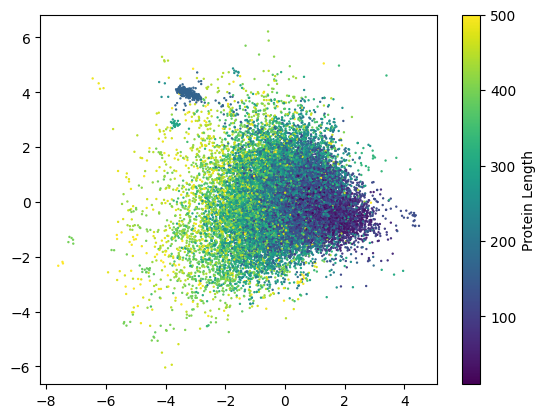

In [60]:
projected_data = torch.matmul(torch.tensor(latent_coord), V[:, :2]) 
import matplotlib.pyplot as plt

plt.scatter(projected_data[:, 0], projected_data[:, 1], s = 0.5, c = lengths, cmap='viridis')
plt.colorbar(label = 'Protein Length')
plt.show()
# plt.savefig("exp_1_latent_Pfam.png")